In [1]:
%load_ext autoreload
%autoreload 2
from KMeans import *
from openml.datasets import list_datasets, get_datasets
import pandas as pd
import warnings
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns
from sklearn.linear_model import LinearRegression
from scipy import stats
from sklearn.datasets import make_blobs
import gc
from importAirbnb import *
from utils.helpers import load_datasets

## Flags

In [2]:
# flag for researching datasets
search = False
# flag for re-measuring time executions
measure = False

## Dataset retrieval

Datasets are retrieved from OpenML using an API. It consists in the following steps:
1. In the query we specify the characteristics of the datasets we want to rietrieve.
2. We obtain the ids of these datasets and save it in dataset_ids.csv
3. We load the datasets with the given ids using get_datasets()
4. We transform them in numpy

In [3]:
query = "NumberOfInstances > 100000 &\
         NumberOfInstances < 1000000 &\
         NumberOfNumericFeatures > 5 &\
         NumberOfNumericFeatures < 50 &\
         NumberOfMissingValues == 0 &\
         NumberOfSymbolicFeatures == 0"

X_list = load_datasets(query, n_datasets = 10, search = search)

## Helpers

In [4]:
def fit_linear_regression(df, x_name, y_name):
    X = df[x_name].to_numpy().reshape(-1, 1)  
    y = df[y_name].to_numpy()

    model = LinearRegression()
    model.fit(X, y);
    print(f'Model with x: {x_name}, y: {y_name}')
    print(f'\tCoefficient: {model.coef_}')
    print(f'\tIntercept: {model.intercept_}')
    return model

In [5]:
def clean_dataset(df):
    # Remove inf values
    df_clean = df.replace([np.inf, -np.inf], np.nan)
    df_clean = df_clean.dropna()
    return df_clean

In [6]:
def generate_clusters(n_clusters=3, d=2, n=100):
    centers = np.random.rand(n_clusters, d) * 15
    cluster_std = np.random.normal(1, 0.2, n_clusters)
    X, y = make_blobs(n_samples=n, cluster_std=cluster_std, centers=centers, n_features=d, random_state=1)

    # print("2d plot")
    # for cluster in range(n_clusters):
    #     plt.scatter(X[y == cluster, 0], X[y == cluster, 1], s=10, label=f"Cluster{cluster}")
    return centers, cluster_std, X, y

## Plot definitions

In [7]:
class color:
   PURPLE = '\033[95m'
   CYAN = '\033[96m'
   DARKCYAN = '\033[36m'
   BLUE = '\033[94m'
   GREEN = '\033[92m'
   YELLOW = '\033[93m'
   RED = '\033[91m'
   BOLD = '\033[1m'
   UNDERLINE = '\033[4m'
   END = '\033[0m'

In [8]:
pad = 20
figsize = (10,8)

In [9]:
def boxplot(df, columns, title, xlabel, ylabel, tick_freq=None):
    plt.figure(figsize=figsize)
    df_melted = pd.melt(df, value_vars=columns)
    ax = sns.boxplot(x="variable", y="value", data=df_melted)
    ax.set_title(title, pad=pad)
    if tick_freq is not None:
        ax.yaxis.set_major_locator(ticker.MultipleLocator(tick_freq))
    ax.set_ylabel(ylabel)
    ax.set_xlabel(xlabel)
    plt.show()

In [10]:
def scatterplot(df, x, y, title, xlabel, ylabel, hue=None):
    plt.figure(figsize=figsize)
    if hue:
        ax = sns.scatterplot(data=df, x=x, y=y, hue = hue, palette=sns.color_palette()[:len(df[hue].unique())]) # palette=sns.color_palette()
    else:
        ax = sns.scatterplot(data=df, x=x, y=y)
    ax.set_title(title, pad=pad)
    ax.set_ylabel(ylabel)
    ax.set_xlabel(xlabel)
    plt.show()

In [11]:
def getPlots(df_, speculation=False):
    sns.set_context("paper", font_scale=1.5)

    df_['ratio_AB_median'] = df_['t_A_median']/df_['t_B_median']
    
    df = clean_dataset(df_)
    
    # Box-plot of medians
    if speculation:
        boxplot(df, columns = ['t_A_median', 't_B_median', 't_correction_median', 't_speculation_median'], title = 'Average execution time of A, B, correction and speculation', xlabel = 'Task', ylabel = 'Execution time in ms')
        
    else:
        boxplot(df, columns = ['t_A_median', 't_B_median'],  title = 'Average execution time of A, B', xlabel = 'Task', ylabel = 'Execution time in ms')
        
    # Box-plot of ratios
    if speculation:
        df_measurements_speculation['ratio_A_correction_median'] = df_measurements_speculation['t_A_median']/df_measurements_speculation['t_correction_median']
        df_measurements_speculation['ratio_B_correction_median'] = df_measurements_speculation['t_B_median']/df_measurements_speculation['t_correction_median']
        df_measurements_speculation['ratio_B_speculation_median'] = df_measurements_speculation['t_B_median']/df_measurements_speculation['t_speculation_median']
        boxplot(df, columns = ['ratio_AB_median'], title = r'Ratio $\frac{median(t_A)}{median(t_B)}$', xlabel = 'Task', ylabel = 'Ratio value')
        boxplot(df, columns = ['ratio_A_correction_median'], title = r'Ratio $\frac{median(t_A)}{median(t_{correction})}$', xlabel = 'Task', ylabel = 'Ratio value')
        boxplot(df, columns = ['ratio_B_correction_median', 'ratio_B_speculation_median'], title = r'Ratio $\frac{median(t_B)}{median(t_{correction})}$ and Ratio $\frac{median(t_B)}{median(t_{speculation})}$', xlabel = 'Task', ylabel = 'Ratio value')

    else:
        boxplot(df, columns = ['ratio_AB_median'], title = r'Ratio $\frac{median(t_A)}{median(t_B)}$', xlabel = 'Task', ylabel = 'Ratio value')
        
    # Scatter plots - n_clusters
    scatterplot(df, x='n_clusters', y='ratio_AB_median', hue='dataset_id',title=r'Relation between n_clusters and $\frac{median(t_A)}{median(t_B)}$', xlabel='k', ylabel=r'$\frac{median(t_A)}{median(t_B)}$')
    scatterplot(df, x='n_clusters', y='ratio_AB_median', hue='n_datapoints',title=r'Relation between n_clusters and $\frac{median(t_A)}{median(t_B)}$', xlabel='k', ylabel=r'$\frac{median(t_A)}{median(t_B)}$')
    scatterplot(df, x='n_clusters', y='ratio_AB_median', hue='n_features',title=r'Relation between n_clusters and $\frac{median(t_A)}{median(t_B)}$', xlabel='k', ylabel=r'$\frac{median(t_A)}{median(t_B)}$')
    scatterplot(df, x='n_datapoints', y='ratio_AB_median', title=r'Relation between n_datapoints and $\frac{median(t_A)}{median(t_B)}$', xlabel='n', ylabel=r'$\frac{median(t_A)}{median(t_B)}$')
    scatterplot(df, x='n_features', y='ratio_AB_median', title=r'Relation between n_features and $\frac{median(t_A)}{median(t_B)}$', xlabel='d', ylabel=r'$\frac{median(t_A)}{median(t_B)}$')
    #scatterplot(df.groupby(['n_clusters']).mean(), x='n_clusters', y='ratio_AB_median', title=r'Relation between n_clusters and $\frac{median(t_A)}{median(t_B)} - aggregation over all datasets $', xlabel='Number of clusters', ylabel=r'$\frac{median(t_A)}{median(t_B)}$')
    #scatterplot(df[df.n_datapoints == df.iloc[0].n_datapoints], x='n_clusters', y='ratio_AB_median', title=r'Relation between n_clusters and $\frac{median(t_A)}{median(t_B)} - fixed dataset $', xlabel='Number of clusters', ylabel=r'$\frac{median(t_A)}{median(t_B)}$')
    
    # Scatter plots - cluster sizes
    df['ratio_max_min_cluster_size'] = df['max_cluster_size']/df['min_cluster_size']
    scatterplot(df, x='median_cluster_size', y='ratio_AB_median', hue='n_datapoints', title=r'Relation between median(cluster_size) and $\frac{median(t_A)}{median(t_B)}$', xlabel='Average cluster size', ylabel=r'$\frac{median(t_A)}{median(t_B)}$')
    scatterplot(df, x='ratio_max_min_cluster_size', y='ratio_AB_median', title=r'Relation between skew in cluster size (i.e:  $\frac{max(cluster-size)}{min(cluster-size)}$) and  $\frac{median(t_A)}{median(t_B)}$', xlabel=r'Skew: $\frac{max(cluster-size)}{min(cluster-size)}$', ylabel=r'$\frac{median(t_A)}{median(t_B)}$')
    scatterplot(df, x='ratio_max_min_cluster_size', y='t_A_median', title=r'Relation between skew in cluster size (i.e:  $\frac{max(cluster-size)}{min(cluster-size)}$) and median(t_A)', xlabel=r'Skew: $\frac{max(cluster-size)}{min(cluster-size)}$', ylabel='median(t_A)')
    scatterplot(df, x='ratio_max_min_cluster_size', y='t_B_median', title=r'Relation between skew in cluster size (i.e: $\frac{max(cluster-size)}{min(cluster-size)}$)', xlabel=r'Skew: $\frac{max(cluster-size)}{min(cluster-size)}$', ylabel='median(t_B)')

## 1. Relation tA/tB, n, k

The implementations of kmeans should have the following complexities:
- Assignment: **O(ndk)**
- Update: **O(d(n+k))**

Even if ideally the complexity of the update should be O(nd) since we are doing only nd suns, we need some work to separate the datapoints using the labels. This leads to extra work which depdends on k. Depending on the implementations we may have the update with complexity O(ndk) or O(d(n+k)). The fastest implementation in numpy is O(d(n+k)).

For more information: https://nicholasvadivelu.com/2021/05/10/fast-k-means/

We therefore expect to have: tA/tB O(nk/(n+k)).
However, we have that usually n >> k, therefore O(nk/(n+k)) ~ O(k).

In this case we have that:
- for fixed n, the ratio tA/tB will grow like k. In particular:
    - The assignment phase will grow with k, since O(ndk)
    - The update phase should be constant with k, since O(d(n+k)) ~ O(dn)
- for fixed k, the ratio tA/tB stay constant around k

### 1.1 Relation tA/tB, k

We fix n (and d) and we plot the evolution of tA/tB for growing k.


We take the dataset with largest d, in our X_list, therefore the last one X[-1], since they are sorted by d.

We want a larger d, because we want a larger time execution. Indeed with small n and d, B executes extremely fast, and the measured execution time is 0. This leads to tA/tB to be infinite, which it's not useful.

We can verify in the plots that tA/tB grows like k, with a slope around 1.5.

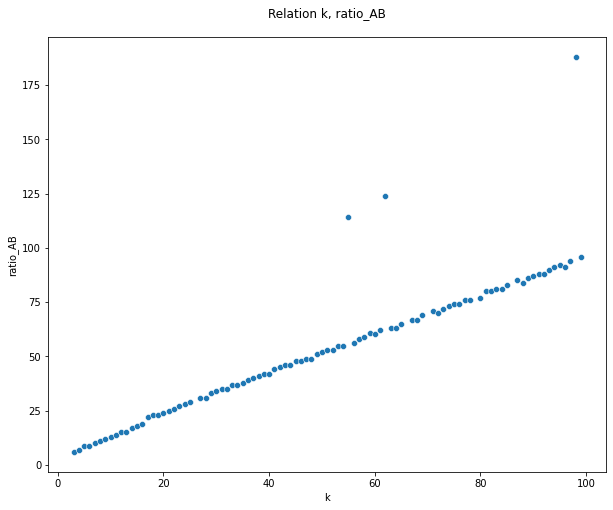

In [12]:
if measure:
    # We select the first dataset in the list of datasets
    X = X_list[-1]
    df = pd.DataFrame(columns=['n_datapoints', 'n_features', 'n_clusters', 't_A_median', 't_A_min', 't_A_max', 't_B_median', 't_B_min', 't_B_max', 'median_cluster_size', 'min_cluster_size', 'max_cluster_size'])
    i = 0
    for K in range(3, 100):
        if K%10 == 0:
            print(K)
        labels, centroids, A_time, B_time = KMeans(X, K, num_iter=100, measure=True)
        # Get cluster size
        clusters_size = np.array([X[labels == k].shape[0] for k in range(K)])
        # Append to df
        df.loc[i] = [X.shape[0], X.shape[1], K, np.median(A_time), np.min(A_time), np.max(A_time), np.median(B_time), np.min(B_time), np.max(B_time), np.nanmean(clusters_size), np.nanmin(clusters_size), np.nanmax(clusters_size)]
        i += 1
    df.to_csv('./data/measurements_1_1.csv', index=False)
    
# Import dataset    
df = pd.read_csv('./data/measurements_1_1.csv')
# Compute ratio
df['ratio_AB_median'] = df['t_A_median']/df['t_B_median']
# Clean dataset
df_clean = clean_dataset(df)
# Plot
scatterplot(df_clean, 'n_clusters', 'ratio_AB_median', 'Relation k, ratio_AB', 'k', 'ratio_AB')

In [13]:
# Fit linear regression
model_k_1 = fit_linear_regression(df_clean, 'n_clusters', 't_A_median')
model_k_2 = fit_linear_regression(df_clean, 'n_clusters', 't_B_median')
model_k_3 = fit_linear_regression(df_clean, 'n_clusters', 'ratio_AB_median')

Model with x: n_clusters, y: t_A_median
	Coefficient: [14.2870083]
	Intercept: 83.24004532044273
Model with x: n_clusters, y: t_B_median
	Coefficient: [-0.00690815]
	Intercept: 15.717153769563875
Model with x: n_clusters, y: ratio_AB_median
	Coefficient: [0.98987452]
	Intercept: 3.8508664386753537


### 1.2 Relation tA/tB, n

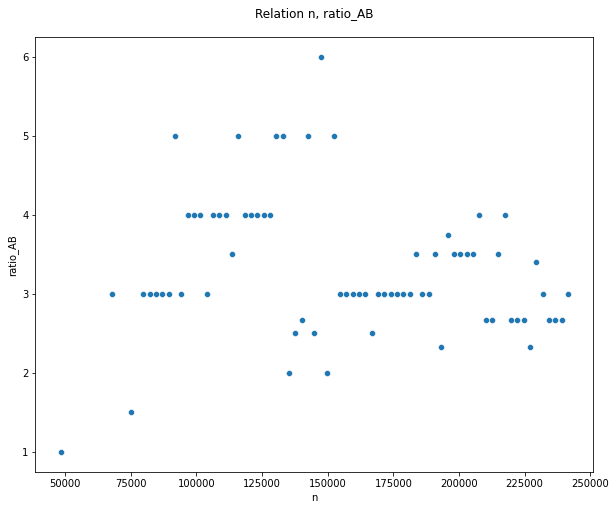

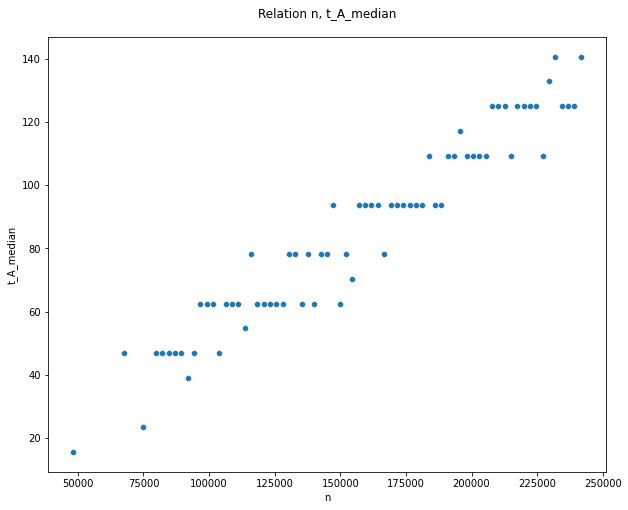

Model with x: n_datapoints, y: t_A_median
	Coefficient: [0.00056924]
	Intercept: -3.734572610981303


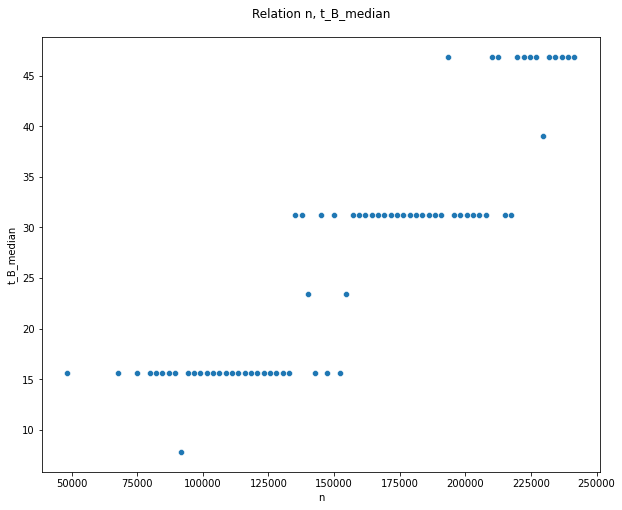

Model with x: n_datapoints, y: t_B_median
	Coefficient: [0.00020407]
	Intercept: -4.661710997700698


LinearRegression()

In [26]:
if measure:
    X_full = X_list[-1]
    df = pd.DataFrame(columns=['n_datapoints', 'n_features', 'n_clusters', 't_A_median', 't_A_min', 't_A_max', 't_B_median', 't_B_min', 't_B_max', 'median_cluster_size', 'min_cluster_size', 'max_cluster_size'])
    i = 0
    K = 4
    for j in range(1,101):
        if j%10 == 0:
            print(j)
        X = X_full[:int(X_full.shape[0]* j/100)]
        labels, centroids, A_time, B_time = KMeans(X, K, num_iter=100, measure=True)
        # Get cluster size
        clusters_size = np.array([X[labels == k].shape[0] for k in range(K)])
        # Append to df
        df.loc[i] = [X.shape[0], X.shape[1], K, np.median(A_time), np.min(A_time), np.max(A_time), np.median(B_time), np.min(B_time), np.max(B_time), np.nanmean(clusters_size), np.nanmin(clusters_size), np.nanmax(clusters_size)]
        i += 1
    df.to_csv('./data/measurements_1_2.csv', index=False)
    
# Import dataset
df = pd.read_csv('./data/measurements_1_2.csv')
# Compute ratio
df['ratio_AB_median'] = df['t_A_median']/df['t_B_median']
# Clean dataset
df_clean = clean_dataset(df)
# Scatterplot
scatterplot(df_clean, 'n_datapoints', 'ratio_AB_median', 'Relation n, ratio_AB', 'n', 'ratio_AB')
scatterplot(df_clean, 'n_datapoints', 't_A_median', 'Relation n, t_A_median', 'n', 't_A_median')
fit_linear_regression(df_clean,'n_datapoints', 't_A_median')
scatterplot(df_clean, 'n_datapoints', 't_B_median', 'Relation n, t_B_median', 'n', 't_B_median')
fit_linear_regression(df_clean,'n_datapoints', 't_B_median')

Text(0, 0.5, 'Feature count')

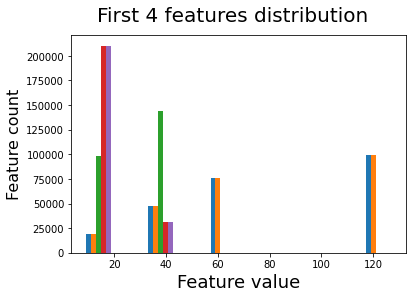

In [18]:
fig = plt.figure()
X_full = X_list[-1]
plt.hist(X_full[:, :5])
fig.suptitle('First 4 features distribution', fontsize=20)
plt.xlabel('Feature value', fontsize=18)
plt.ylabel('Feature count', fontsize=16)

In [19]:
model_n = fit_linear_regression(df_clean,'n_datapoints', 'ratio_AB_median')

Model with x: n_datapoints, y: ratio_AB_median
	Coefficient: [-2.38048928e-06]
	Intercept: 3.679974979912209


### 1.2.2 Synthetic dataset

Redo the measurements with a synthetic dataset with same number of d and n as before, but different data distribution, which in particular now is Gaussian.

10
20
30
40
50
60
70


C:\Users\stefa\PycharmProjects\DIAS-semester-project\KMeans.py:23: RuntimeWarning: invalid value encountered in true_divide
  return np.apply_along_axis(fn, 0, X) / group_counts


80
90
100


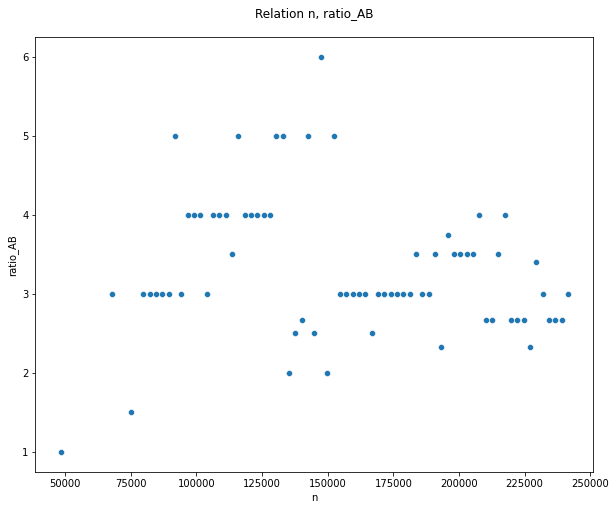

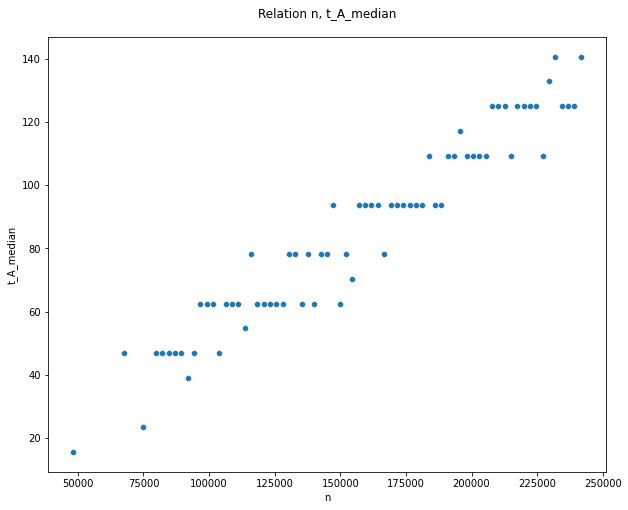

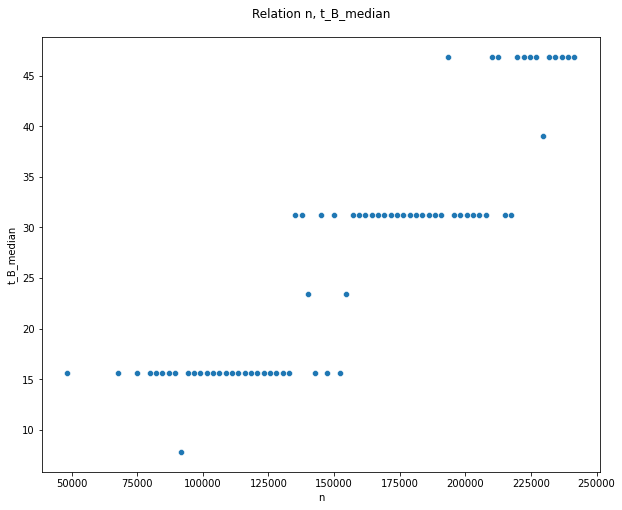

In [25]:
measure = True
if measure:
    n, d = X_list[-1].shape
    centers, cluster_std, X_full, y = generate_clusters(n_clusters = 4, d = d, n = n)
    df = pd.DataFrame(columns=['n_datapoints', 'n_features', 'n_clusters', 't_A_median', 't_A_min', 't_A_max', 't_B_median', 't_B_min', 't_B_max', 'median_cluster_size', 'min_cluster_size', 'max_cluster_size'])
    i = 0
    K = 4
    for j in range(1,101):
        if j%10 == 0:
            print(j)
        X = X_full[:int(X_full.shape[0]* j/100)]
        labels, centroids, A_time, B_time = KMeans(X, K, num_iter=100, measure=True)
        # Get cluster size
        clusters_size = np.array([X[labels == k].shape[0] for k in range(K)])
        # Append to df
        df.loc[i] = [X.shape[0], X.shape[1], K, np.median(A_time), np.min(A_time), np.max(A_time), np.median(B_time), np.min(B_time), np.max(B_time), np.nanmean(clusters_size), np.nanmin(clusters_size), np.nanmax(clusters_size)]
        i += 1
    df.to_csv('./data/measurements_1_2_2.csv', index=False)
    
# Import dataset
df = pd.read_csv('./data/measurements_1_2_2.csv')
# Compute ratio
df['ratio_AB_median'] = df['t_A_median']/df['t_B_median']
# Clean dataset
df_clean = clean_dataset(df)
# Scatterplot
scatterplot(df_clean, 'n_datapoints', 'ratio_AB_median', 'Relation n, ratio_AB', 'n', 'ratio_AB')
scatterplot(df_clean, 'n_datapoints', 't_A_median', 'Relation n, t_A_median', 'n', 't_A_median')
scatterplot(df_clean, 'n_datapoints', 't_B_median', 'Relation n, t_B_median', 'n', 't_B_median')

Text(0, 0.5, 'Feature count')

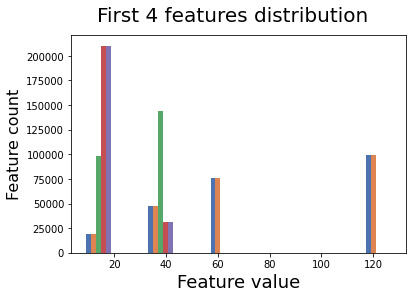

In [15]:
fig = plt.figure()
plt.hist(X_full[:, :5])
fig.suptitle('First 4 features distribution', fontsize=20)
plt.xlabel('Feature value', fontsize=18)
plt.ylabel('Feature count', fontsize=16)

In [16]:
model_n = fit_linear_regression(df_clean,'n_datapoints', 'ratio_AB_median')

Model with x: n_datapoints, y: ratio_AB_median
	Coefficient: [2.7681993e-05]
	Intercept: 0.3829465186680103


## 2. Measurements basic k-means

We do now some measurements on different datasets having:
- different n, number of datapoints
- different (incresing) d, number of features

For each dataset we run kmeans with different number of clusters.

In the plots we can see how tA/tB is still proportional to k, with a slope value around 1.79.

However we can also see how the slope and the offset slightly change from dataset to dataset.

We should therefore understand if this change of slope and offset depends on n, or d, or both. Or maybe on something else.

The study is done in the following section.

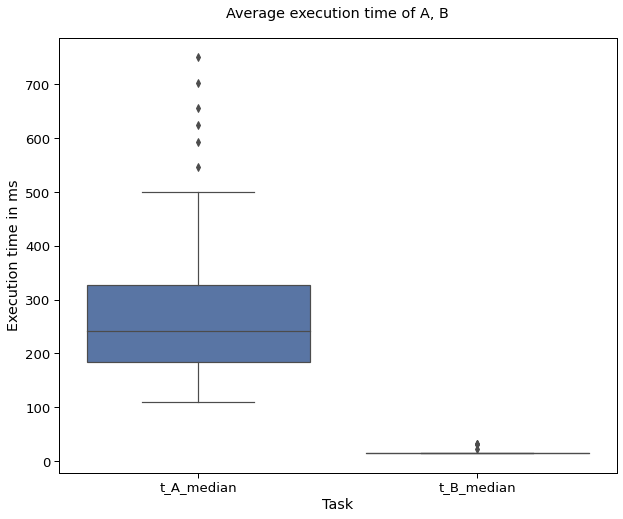

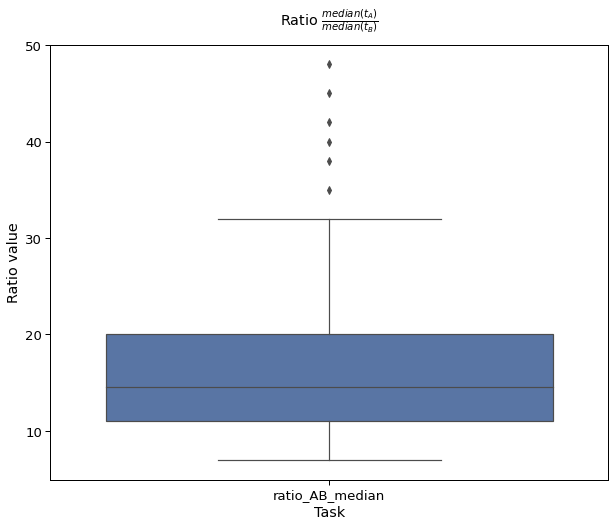

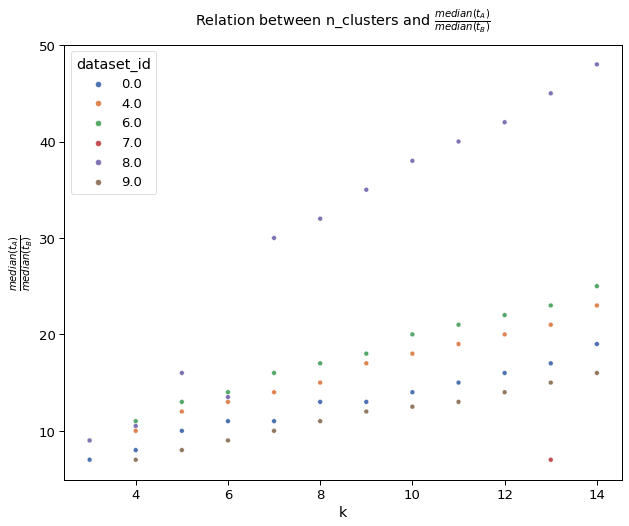

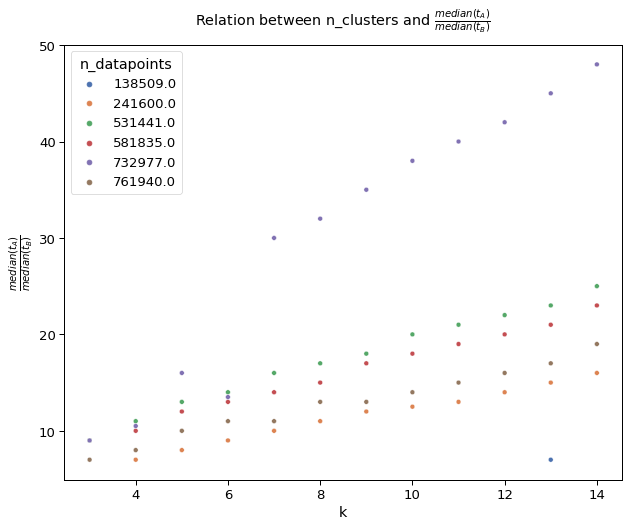

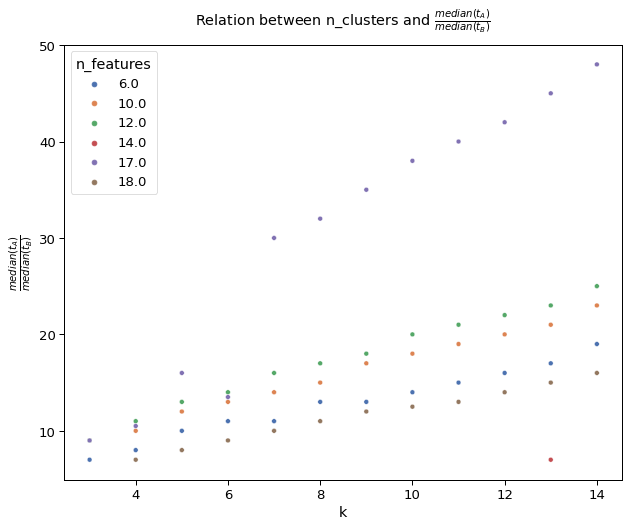

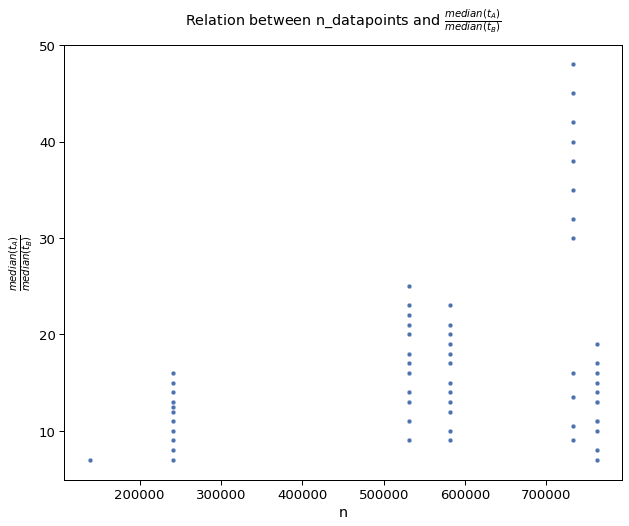

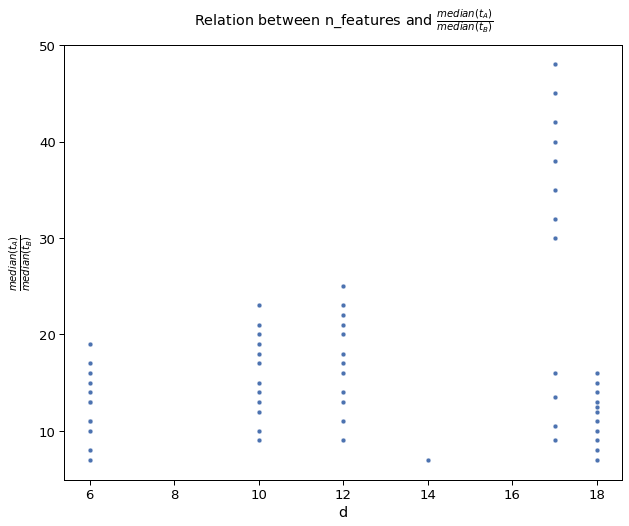

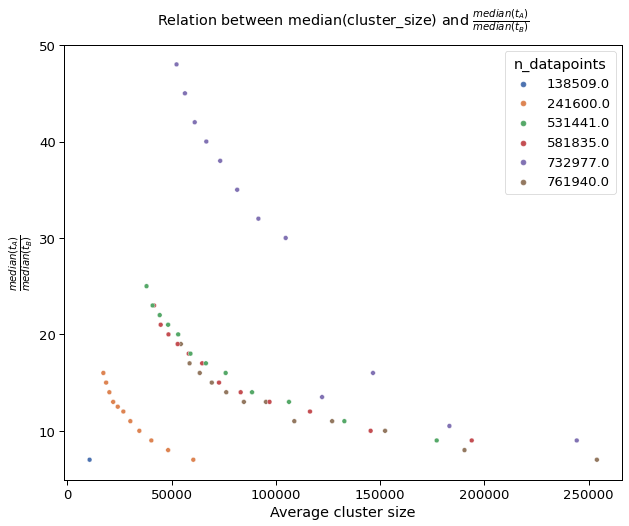

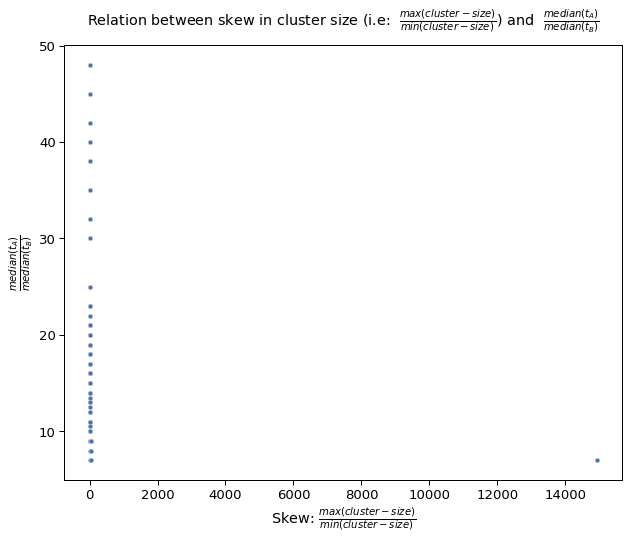

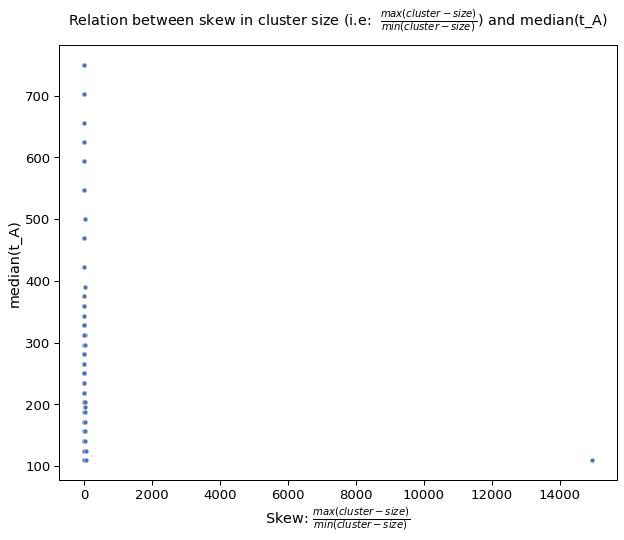

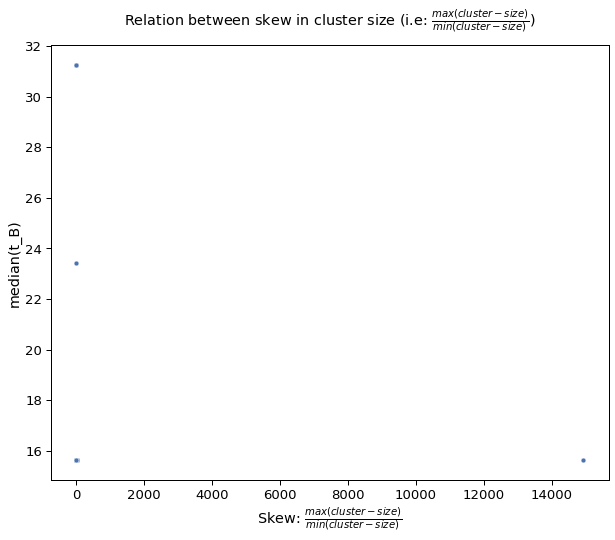

In [17]:
if measure:
    with warnings.catch_warnings():
        warnings.simplefilter("ignore", category=RuntimeWarning)
        i = 0
        df_measurements = pd.DataFrame(columns=['dataset_id','n_datapoints', 'n_features', 'n_clusters', 't_A_median', 't_A_min', 't_A_max', 't_B_median', 't_B_min', 't_B_max', 'median_cluster_size', 'min_cluster_size', 'max_cluster_size'])
        for x_index, X in enumerate(X_list):
            print(f"\nProcessing {x_index + 1}° dataset...")
            for K in range(3, 15):
                # Fit kmeans
                print(f"|{K}|", end='')
                labels, centroids, A_time, B_time = KMeans(X, K, num_iter=100, measure=True)
                # Get cluster size
                clusters_size = np.array([X[labels == k].shape[0] for k in range(K)])
                # Append to df
                df_measurements.loc[i] = [x_index, X.shape[0], X.shape[1], K, np.median(A_time), np.min(A_time), np.max(A_time), np.median(B_time), np.min(B_time), np.max(B_time), np.nanmean(clusters_size), np.nanmin(clusters_size), np.nanmax(clusters_size)]
                i += 1
        df_measurements.to_csv('./data/measurements_2.csv', index=False)
        
df_measurements = pd.read_csv('./data/measurements_2.csv')
getPlots(df_measurements)

In [18]:
df_clean = clean_dataset(df_measurements)
print(color.BOLD + 'Linear regression with all datasets:' + color.END)
fit_linear_regression(df_clean, 'n_clusters', 'ratio_AB_median')
print('\n')
for v in df_clean.dataset_id.unique():
    df_clean_subset = df_clean[df_clean.dataset_id == v]
    print(color.BOLD +f'\nLinear regression for dataset_id = {v}:'+ color.END)
    fit_linear_regression(df_clean_subset, 'n_clusters', 'ratio_AB_median')

Linear regression with all datasets:
Model with x: n_clusters, y: ratio_AB_median
	Coefficient: [1.52511848]
	Intercept: 4.2406398104265435



Linear regression for dataset_id = 0.0:
Model with x: n_clusters, y: ratio_AB_median
	Coefficient: [0.99300699]
	Intercept: 4.392773892773896

Linear regression for dataset_id = 4.0:
Model with x: n_clusters, y: ratio_AB_median
	Coefficient: [1.23426573]
	Intercept: 5.425407925407926

Linear regression for dataset_id = 6.0:
Model with x: n_clusters, y: ratio_AB_median
	Coefficient: [1.38111888]
	Intercept: 5.677156177156181

Linear regression for dataset_id = 7.0:
Model with x: n_clusters, y: ratio_AB_median
	Coefficient: [0.]
	Intercept: 7.0

Linear regression for dataset_id = 8.0:
Model with x: n_clusters, y: ratio_AB_median
	Coefficient: [3.77972028]
	Intercept: -2.210955710955698

Linear regression for dataset_id = 9.0:
Model with x: n_clusters, y: ratio_AB_median
	Coefficient: [0.86818182]
	Intercept: 3.7772727272727256


In [19]:
df_clean[df_clean.dataset_id == 8][['n_datapoints','n_features']].iloc[0]

n_datapoints    732977.0
n_features          17.0
Name: 96, dtype: float64

## 3. Study of slope, offset variations based on n and d

In order to understand if the changement of slope depends on n or d we:
1. generate a syntetic dataset in high dimension, with d = 50, n = 10e+6
2. we first iterate increasing the percentage of n used
3. we then iterate increasing the percentage of d used

We used a synthetic dataset with clusters generated as gaussian distribution in d with different means and std, because this way, whichever is the subset of d, we always have clustered datapoints, since the gaussian distribution is respected in all d.

In both 2. and 3. we measure the dependence of tA/tB on k.

In [21]:
centers, cluster_std, X_full, y = generate_clusters(n_clusters = 10, d = 20, n = int(10e+5))

### 3.1 Slope, offset variations based on n

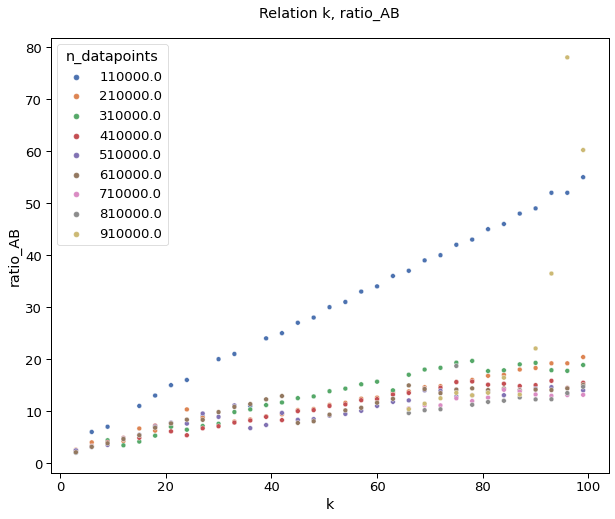

In [22]:
if measure:
    df = pd.DataFrame(columns=['n_datapoints', 'n_features', 'n_clusters', 't_A_median', 't_A_min', 't_A_max', 't_B_median', 't_B_min', 't_B_max', 'median_cluster_size', 'min_cluster_size', 'max_cluster_size'])
    i = 0
    for j in range(1,101,10):
        X = X_full[:int(X_full.shape[0]* j/100)]
        for K in range(3,100,3):
            if i % 20 == 0:
                print(f'Percentage of n used: {j}%\nNumber of clusters k: {K}')
            labels, centroids, A_time, B_time = KMeans(X, K, num_iter=100, measure=True)
            # Get cluster size
            clusters_size = np.array([X[labels == k].shape[0] for k in range(K)])
            # Append to df
            df.loc[i] = [X.shape[0], X.shape[1], K, np.median(A_time), np.min(A_time), np.max(A_time), np.median(B_time), np.min(B_time), np.max(B_time), np.nanmean(clusters_size), np.nanmin(clusters_size), np.nanmax(clusters_size)]
            i += 1
    df.to_csv('./data/measurements_3_1.csv', index=False)
    
# Import dataset
df = pd.read_csv('./data/measurements_3_1.csv')
# Compute ratio
df['ratio_AB_median'] = df['t_A_median']/df['t_B_median']
# Clean dataset
df_clean = clean_dataset(df)
# Scatterplot
scatterplot(df_clean, 'n_clusters', 'ratio_AB_median', 'Relation k, ratio_AB', 'k', 'ratio_AB',  hue='n_datapoints')

### 3.2 Slope, offset variations based on d

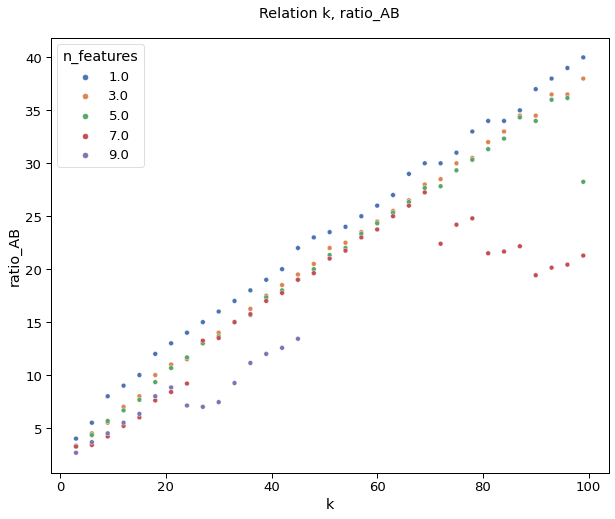

In [23]:
if measure:
    df = pd.DataFrame(columns=['n_datapoints', 'n_features', 'n_clusters', 't_A_median', 't_A_min', 't_A_max', 't_B_median', 't_B_min', 't_B_max', 'median_cluster_size', 'min_cluster_size', 'max_cluster_size'])
    i = 0
    for j in range(1,101,10):
        X = X_full[:, :int(np.ceil(X_full.shape[1]* j/100))]
        for K in range(3,100,3):
            if i % 20 == 0:
                print(f'Percentage of d used: {j}%\nNumber of clusters k: {K}')
            labels, centroids, A_time, B_time = KMeans(X, K, num_iter=100, measure=True)
            # Get cluster size
            clusters_size = np.array([X[labels == k].shape[0] for k in range(K)])
            # Append to df
            df.loc[i] = [X.shape[0], X.shape[1], K, np.median(A_time), np.min(A_time), np.max(A_time), np.median(B_time), np.min(B_time), np.max(B_time), np.nanmean(clusters_size), np.nanmin(clusters_size), np.nanmax(clusters_size)]
            i += 1
    df.to_csv('./data/measurements_3_2.csv', index=False)
    
# Import dataset
df = pd.read_csv('./data/measurements_3_2.csv')
# Compute ratio
df['ratio_AB_median'] = df['t_A_median']/df['t_B_median']
# Clean dataset
df_clean = clean_dataset(df)
# Scatterplot
scatterplot(df_clean, 'n_clusters', 'ratio_AB_median', 'Relation k, ratio_AB', 'k', 'ratio_AB', hue='n_features')

In [24]:
if measure:
    X_full = X_list[-1]
    df = pd.DataFrame(columns=['n_datapoints', 'n_features', 'n_clusters', 't_A_median', 't_A_min', 't_A_max', 't_B_median', 't_B_min', 't_B_max', 'median_cluster_size', 'min_cluster_size', 'max_cluster_size'])
    i = 0
    K = 4
    for j in range(1,101):
        if j%10 == 0:
            print(j)
        X = X_full[:int(X_full.shape[0]* j/100)]
        labels, centroids, A_time, B_time = KMeans(X, K, num_iter=100, measure=True)
        # Get cluster size
        clusters_size = np.array([X[labels == k].shape[0] for k in range(K)])
        # Append to df
        df.loc[i] = [X.shape[0], X.shape[1], K, np.median(A_time), np.min(A_time), np.max(A_time), np.median(B_time), np.min(B_time), np.max(B_time), np.nanmean(clusters_size), np.nanmin(clusters_size), np.nanmax(clusters_size)]
        i += 1
    df.to_csv('./data/measurements_1_2_2.csv', index=False)
    
# Import dataset
df = pd.read_csv('./data/measurements_1_2_2.csv')
# Compute ratio
df['ratio_AB_median'] = df['t_A_median']/df['t_B_median']
# Clean dataset
df_clean = clean_dataset(df)
# Scatterplot
scatterplot(df_clean, 'n_datapoints', 'ratio_AB_median', 'Relation n, ratio_AB', 'n', 'ratio_AB')

FileNotFoundError: [Errno 2] No such file or directory: './data/measurements_1_2_2.csv'

## 4. Measurements speculated k-means

In [27]:
measure = False
if measure:
    with warnings.catch_warnings():
        warnings.simplefilter("ignore", category=RuntimeWarning)
        i = 0
        subsample_size=0.01
        df_measurements_speculation = pd.DataFrame(columns=['dataset_id', 'n_datapoints', 'n_features', 'n_clusters', 't_A_median', 't_A_min', 't_A_max', 't_B_median', 't_B_min', 't_B_max', 'median_cluster_size', 'min_cluster_size', 'max_cluster_size',\
                                                't_speculation_median', 't_speculation_min', 't_speculation_max', 't_correction_median', 't_correction_min', 't_correction_max', 'subsample_size'])
        for x_index, X in enumerate(X_list):
            print(f"\nProcessing {x_index + 1}° dataset...")
            for K in range(3, 15):
                # Fit kmeans
                print(f"|{K}|", end='')
                labels, centroids, A_time, B_time, speculation_time, correction_time  = KMeans_speculation(X, K, num_iter=100, measure=True, subsample_size = subsample_size)
                # Get cluster size
                clusters_size = np.array([X[labels == k].shape[0] for k in range(K)])
                # Append to df
                df_measurements_speculation.loc[i] = [x_index, X.shape[0], X.shape[1], K, np.median(A_time), np.min(A_time), np.max(A_time), np.median(B_time),\
                                          np.min(B_time), np.max(B_time), np.nanmean(clusters_size), np.nanmin(clusters_size), np.nanmax(clusters_size),\
                                          np.median(speculation_time), np.min(speculation_time), np.max(speculation_time), np.median(correction_time), np.min(correction_time), np.max(correction_time), subsample_size]
                i += 1
        df_measurements_speculation.to_csv('./data/measurements_4.csv', index=False)

In [28]:
df_measurements_speculation = pd.read_csv('./data/measurements_4.csv')
getPlots(df_measurements_speculation, speculation = True)

KeyError: 't_A_median'